# Loading the data

In [1]:
# @title Install dependencies

#!pip install pandas --quiet
#!pip install seaborn --quiet
#!pip install  pyarrow # may be needed to read data file

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from sklearn.decomposition import PCA             # just if needed
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import Ridge

## For this example, we have pre-computed event triggered responses and saved them to figshare.
#### To access the full dataset, see `Allen_neuromatch_example_2.ipynb`, or go to the links at the bottom of this notebook
###This cell will download the responses.

In [3]:
# @title Data retrieval
import os, requests

fname = "allen_visual_behavior_2p_change_detection_familiar_novel_image_sets.parquet"
url = "https://ndownloader.figshare.com/files/28470255"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

### Then we open it using the pandas `read_parquet` method


(parquet is just another file format)

In [4]:
filename = "allen_visual_behavior_2p_change_detection_familiar_novel_image_sets.parquet"
data = pd.read_parquet(filename)

# DATA_ PROCESSING: Start here after loading data

In [5]:
#THIS IS WHERE THE FUN STARTS
# Define a function to map combinations to numbers 1-4
def map_conditions(row):
    if row['exposure_level'] == "familiar" and row['is_change'] == True:
        return 1
    elif row['exposure_level'] == "familiar" and row['is_change'] == False:
        return 2
    elif row['exposure_level'] == "novel" and row['is_change'] == True:
        return 3
    elif row['exposure_level'] == "novel" and row['is_change'] == False:
        return 4


# Apply the function to create the new column
#filtered_df['condition'] = filtered_df.apply(map_conditions, axis=1)

#print(filtered_df.shape)

In [6]:
data['condition'] = data.apply(map_conditions, axis=1)

In [7]:
outliers = []
data_traces = data.trace.values
for i in range(len(data_traces)):
    outliers.append((data_traces[i]<1).all())

data_subset_rmo = data[outliers]

In [8]:
def restrict_neurons_with_all_conditions(df):
    # Group by neuron and find unique conditions for each neuron
    neuron_conditions = df.groupby('cell_specimen_id')['condition'].unique()
    # filtering only neurons that have trials in all 4 conditions
    neurons_with_all_conditions = neuron_conditions[
        neuron_conditions.apply(lambda x: {1, 2, 3, 4}.issubset(x))
    ].index
    # Filter the data for those neurons
    filtered_d = df[df['cell_specimen_id'].isin(neurons_with_all_conditions)]
    return filtered_d
filtered_data = restrict_neurons_with_all_conditions(data_subset_rmo)

In [9]:
def verify_filtered_data(df):
    condition_counts = df.groupby('cell_specimen_id')['condition'].nunique()
    return (condition_counts == 4).all()
print(f"Verification result: {verify_filtered_data(filtered_data)}")

Verification result: True


In [10]:
#how many trials of each type per neuron? -> calculate length of each condition for each neuron - creating the trial counts variable
# Group by cell_id and 'condition', then count the number of occurrences
trial_counts = filtered_data.groupby(['cell_specimen_id', 'condition']).size().reset_index(name='trial_count')

print(trial_counts)


     cell_specimen_id  condition  trial_count
0          1086489847          1          204
1          1086489847          2          190
2          1086489847          3          218
3          1086489847          4          217
4          1086489860          1          203
..                ...        ...          ...
383        1086567017          4          184
384        1086567589          1          493
385        1086567589          2          304
386        1086567589          3          303
387        1086567589          4          152

[388 rows x 3 columns]


In [12]:
# Group by 'condition' and find the minimum 'trial_count' for each condition
min_trial_counts = trial_counts.groupby('condition')['trial_count'].min().reset_index()

# For each condition, find the neuron_id corresponding to the minimum trial_count
#min_trial_neurons = trial_counts.loc[trial_counts.groupby('condition')['trial_count'].idxmin()].reset_index(drop=True)

# Merge the two dataframes to get the condition, trial_count, and neuron_id together
#result = pd.merge(min_trial_counts, min_trial_neurons, on=['condition', 'trial_count'], suffixes=('', '_min'))

# Select only the relevant columns
min_trial_counts = min_trial_counts[['condition', 'trial_count']]

print(min_trial_counts)

   condition  trial_count
0          1          122
1          2          127
2          3           82
3          4          101


In [13]:
#ALTERNATIVE OPTION
# Sort the dataframe by 'condition' and 'trial_count' - in case we did not want the minimum but another benchmark
sorted_trial_counts = trial_counts.sort_values(by=['condition', 'trial_count'])

# Group by 'condition' and take the nth smallest 'trial_count'
second_trial_counts = sorted_trial_counts.groupby('condition').nth(0).reset_index()

print(second_trial_counts)

   condition  cell_specimen_id  trial_count
0          1        1086498976          122
1          2        1086495377          127
2          3        1086490603           82
3          4        1086498820          101


Now we need to get all neurons to have the same number of trials per condition. 

In [14]:
#CALCULATE MIN TRIALS
# Calculate the minimum number of trials for each condition
min_trials_per_condition = trial_counts.groupby('condition')['trial_count'].min()
min_trials_per_condition

condition
1    122
2    127
3     82
4    101
Name: trial_count, dtype: int64

In [15]:
#MIN_TRIALS DICTIONARY
# Convert min_trials_df to a dictionary for quick lookup
min_trials_dict = min_trials_per_condition.to_dict()
print(min_trials_dict)

{1: 122, 2: 127, 3: 82, 4: 101}


In [16]:
# Function to sample trials
def sample_trials(group, min_trials_dict, random_seed=42):
    condition = group['condition'].iloc[0]  # Extract condition from group
    min_trials = min_trials_dict.get(condition, None)  # Get minimum trials for the condition
    if min_trials is not None and len(group) > min_trials:
        return group.sample(min_trials, random_state=random_seed)
    return group


In [17]:
# Group by 'cell_id' and 'condition', then sample trials to match the minimum
balanced_df = (
    filtered_data.groupby(['cell_specimen_id', 'condition'], group_keys=False)
    .apply(lambda x: sample_trials(x, min_trials_dict))
)

#print(balanced_df)

In [18]:
#CHECKS WHETHER THINGS WORKED
#how many trials of each type per neuron? -> calculate length of each condition for each neuron
# Group by cell_id and 'condition', then count the number of occurrences
print(min_trials_dict)
trial_counts2 = balanced_df.groupby(['cell_specimen_id', 'condition']).size().reset_index(name='trial_count')

print(trial_counts2)

{1: 122, 2: 127, 3: 82, 4: 101}
     cell_specimen_id  condition  trial_count
0          1086489847          1          122
1          1086489847          2          127
2          1086489847          3           82
3          1086489847          4          101
4          1086489860          1          122
..                ...        ...          ...
383        1086567017          4          101
384        1086567589          1          122
385        1086567589          2          127
386        1086567589          3           82
387        1086567589          4          101

[388 rows x 3 columns]


array([[<AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>],
       [<AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'4'}>]], dtype=object)

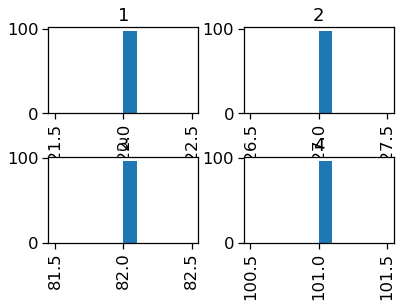

In [19]:
trial_counts2.hist(column='trial_count', by="condition")

In [20]:
# Check if all neurons have the minimum number of trials per condition
correct_counts = trial_counts2.groupby('condition')['trial_count'].nunique() == 1

print("All neurons have the same number of trials per condition:")
print(correct_counts)

All neurons have the same number of trials per condition:
condition
1    True
2    True
3    True
4    True
Name: trial_count, dtype: bool


We now need to create a feature matrix X for our decoding analysis. X should be an array containing the trace values of shape (number of neurons, number of trials, number of timepoints).

In [21]:
# we first determine our dimensions and initiate an empty numpy array of that size
N = len(balanced_df.cell_specimen_id.unique()) # the number of individual neurons left after subsetting above, here 97
S = sum(min_trial_counts.trial_count) # the *total* number of trials across conditions, here 432
T = len(balanced_df.trace.values[0]) # the number of timepoints within each trial, here 85
X = np.zeros((S,N,T))

In [22]:
# we then loop over the three dimensions and extract the values from the dataframe for each
for n, cell_id in enumerate(balanced_df.cell_specimen_id.unique()):
    neuron_data = balanced_df[balanced_df.cell_specimen_id==cell_id] # get each single neuron's data by indexing the column cell_specimen_id
    for s in range(S):
        # y[s] = neuron_data.condition.values[s]
        for t in range(T):
            X[s,n,t] = neuron_data.trace.values[s][t] # each trial is a row in the dataframe, and the column trace contains an array of trace values over time 

We also need the labels y for our model. These are now stored in the new column called condition, and since we have matched the trials across neurons, we can simply use a single neuron's label values:

In [23]:
y = neuron_data.condition.values

display(X.shape,y.shape)

(432, 97, 85)

(432,)

In [24]:
### Logistic Regression Models ###

# Create a pipeline for Logistic Regression 
Cs = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
pipe_logistic = make_pipeline(
    StandardScaler(), # 'pca', PCA(n_components = 0.9) # just if needed to reduce noise or improve the prediction(s)
    LogisticRegressionCV(random_state = 0, cv = 10, penalty='l2', Cs=Cs, max_iter=1000, n_jobs=-1) # 10 fold cross validation
   )

Steps:

* Loop over k fold stratified cross-validation:
* For each of the k loops, loop over timepoints:
* For each timepoint, split X and y into training and test set using indices for that fold
* Fit pipeline to training data
* Predict on test data
* Save all predicted y labels from each fold
* Output should be T vectors `y_predicted` of the same size of `y` (length 432, one label for each trial) containing the predicted labels for each timepoint

Note that this will take some time to run. If you do not want to use several cores, set n_jobs in cell above to 1.

In [25]:
n_folds = 10 # number of folds for k-fold CV
folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=123) # initialise folds generator
y_pred = np.zeros((T, y.shape[0])) # initialise empty array to hold the predicted labels at each timepoint
scores = np.zeros((n_folds, T)) # optional: create array to hold scores for each fold

for i, (train_ind, test_ind) in enumerate(folds.split(X[:,:,0], y)): # loop over k folds using the training and test indices from StratifiedKFold
    for t in range(T): # loop over timepoints
        X_train = X[train_ind,:,t] # split into training and test set
        y_train = y[train_ind]
        X_test = X[test_ind,:,t]
        y_test = y[test_ind]
        pipe_logistic.fit(X_train, y_train) # fit pipeline to training set
        y_pred[t, test_ind] = pipe_logistic.predict(X_test) # predict in test set
        # if you are interested in performance at each fold, save the scores from each of the folds:
        scores[i,t] = pipe_logistic.score(X_test, y_test)

We can then use the predicted labels to compute the accuracy and confusion matrix at each timepoint:

In [75]:
# initialise empty arrays to hold output
acc = np.zeros(T)
conf_mat = np.zeros((4,4,T))
for t in range(T):
    acc[t] = sum(y_pred[t,:]==y)/len(y) # accuracies are the sum of correctly predicted labels divided by the number of trials
    conf_mat[:,:,t] = confusion_matrix(y,y_pred[t]) # one confusion matrix per timepoint

Check the maximum accuracy to see the timepoint at which the decoder predicts best (to see if it picked up anything meaningful at all)

In [27]:
max(acc)

0.8541666666666666

Finally, generate some plots to investigate prediction accuracies. First calculate the chance level (not sure if this is correct, but I think it's not 0.25 since we have different proportions of each stimulus category?)

In [28]:
chance=np.max(min_trial_counts.trial_count.values/S)

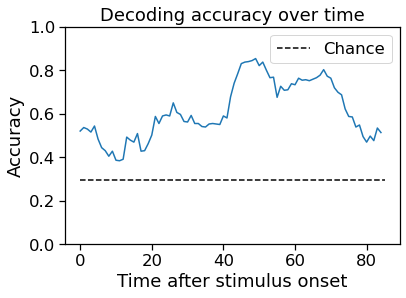

In [77]:
plt.subplot()
plt.plot(range(T), acc)
plt.xlabel('Time after stimulus onset')
plt.ylabel('Accuracy')
plt.hlines(y=chance, xmin=0, xmax=T, label='Chance', linestyles='dashed', colors='black')
plt.legend()
plt.ylim((0,1))
plt.title("Decoding accuracy over time")
plt.show()

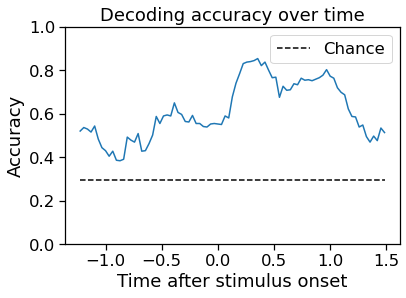

In [85]:
#adding time
plt.subplot()
plt.plot(time, acc)
plt.xlabel('Time after stimulus onset')
plt.ylabel('Accuracy')
plt.hlines(y=chance, xmin=min(time),xmax=max(time),label='Chance', linestyles='dashed', colors='black')
plt.legend()
plt.ylim((0,1))
plt.title("Decoding accuracy over time")
plt.show()



In [72]:
acc.shape

(85,)

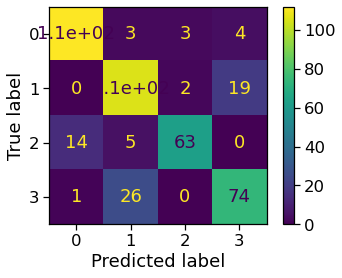

In [86]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat[:,:,50],
                              display_labels=None)
disp.plot()


In [45]:
conf_mat[0,:,2]

array([63., 46.,  5.,  8.])

In [61]:
time=data.trace_timestamps.values[1][:]
print(time)

[-1.22813391 -1.1958146  -1.16349529 -1.13117597 -1.09885666 -1.06653735
 -1.03421803 -1.00189872 -0.96957941 -0.93726009 -0.90494078 -0.87262146
 -0.84030215 -0.80798284 -0.77566352 -0.74334421 -0.7110249  -0.67870558
 -0.64638627 -0.61406696 -0.58174764 -0.54942833 -0.51710902 -0.4847897
 -0.45247039 -0.42015108 -0.38783176 -0.35551245 -0.32319314 -0.29087382
 -0.25855451 -0.22623519 -0.19391588 -0.16159657 -0.12927725 -0.09695794
 -0.06463863 -0.03231931  0.          0.03231931  0.06463863  0.09695794
  0.12927725  0.16159657  0.19391588  0.22623519  0.25855451  0.29087382
  0.32319314  0.35551245  0.38783176  0.42015108  0.45247039  0.4847897
  0.51710902  0.54942833  0.58174764  0.61406696  0.64638627  0.67870558
  0.7110249   0.74334421  0.77566352  0.80798284  0.84030215  0.87262146
  0.90494078  0.93726009  0.96957941  1.00189872  1.03421803  1.06653735
  1.09885666  1.13117597  1.16349529  1.1958146   1.22813391  1.26045323
  1.29277254  1.32509185  1.35741117  1.38973048  1.4

In [114]:
# Ensure the time array is the correct length
assert len(time) == conf_mat.shape[2]

# Define the new labels for the legend
new_labels = ['Familiar deviant', 'Familiar omitted', 'Novel deviant','Novel omitted']

# Plot each true label's predicted label values across time points
for true_label in range(4):
    plt.figure()
    for pred_label in range(4):
        plt.plot(time, conf_mat[true_label, pred_label, :], label=f'Pred {pred_label}')
    
    plt.xlabel('Time')
    plt.ylabel('Confusion Value')
    plt.title(f'Confusion Matrix for true {new_labels[true_label]}')
    # Add a vertical dotted line at t=0
    plt.axvline(x=0, color='k', linestyle='--', linewidth=0.8)
    # Manually set the legend labels
    plt.legend(labels=new_labels,loc='upper left',fontsize='xx-small', bbox_to_anchor=(1.15, 1.05))
    #plt.tight_layout()
    plt.savefig(f"conf_mat_{true_label}.jpeg", dpi=400,bbox_inches='tight')  # Optional: increase dpi for higher quality
    plt.close()  # Close the figure to avoid display in interactive environments
    #plt.show()

In [97]:
#simulating accuracy with random data

from collections import Counter
#simulating random dataframe
print(X.shape)
print(Counter(y))
# Get the proportions of each category in y
category_counts = Counter(y)
total_samples = len(y)

# Initialize X_simulated with random values from a normal distribution
X_simulated = np.random.randn(432, 97, 85)

# Generate y_simulated with the same proportions
y_simulated = np.zeros(total_samples, dtype=int)
current_index = 0

for category, count in category_counts.items():
    y_simulated[current_index:current_index + count] = category
    current_index += count

# Shuffle y_simulated to randomize the order
np.random.shuffle(y_simulated)

print("Shape of X_simulated:", X_simulated.shape)
print("Shape of y_simulated:", y_simulated.shape)
print("Category counts in y_simulated:", Counter(y_simulated))

(432, 97, 85)
Counter({2: 127, 1: 122, 4: 101, 3: 82})
Shape of X_simulated: (432, 97, 85)
Shape of y_simulated: (432,)
Category counts in y_simulated: Counter({2: 127, 1: 122, 4: 101, 3: 82})


In [98]:
n_folds = 10 # number of folds for k-fold CV
folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=123) # initialise folds generator
y_pred2 = np.zeros((T, y.shape[0])) # initialise empty array to hold the predicted labels at each timepoint
scores2 = np.zeros((n_folds, T)) # optional: create array to hold scores for each fold

for i, (train_ind, test_ind) in enumerate(folds.split(X_simulated[:,:,0], y_simulated)): # loop over k folds using the training and test indices from StratifiedKFold
    for t in range(T): # loop over timepoints
        X_train = X_simulated[train_ind,:,t] # split into training and test set
        y_train = y_simulated[train_ind]
        X_test = X_simulated[test_ind,:,t]
        y_test = y_simulated[test_ind]
        pipe_logistic.fit(X_train, y_train) # fit pipeline to training set
        y_pred2[t, test_ind] = pipe_logistic.predict(X_test) # predict in test set
        # if you are interested in performance at each fold, save the scores from each of the folds:
        scores2[i,t] = pipe_logistic.score(X_test, y_test)

In [99]:
# initialise empty arrays to hold output
acc2 = np.zeros(T)
conf_mat2 = np.zeros((4,4,T))
for t in range(T):
    acc2[t] = sum(y_pred[t,:]==y_simulated)/len(y_simulated) # accuracies are the sum of correctly predicted labels divided by the number of trials
    conf_mat2[:,:,t] = confusion_matrix(y_simulated,y_pred[t]) # one confusion matrix per timepoint

(85,)


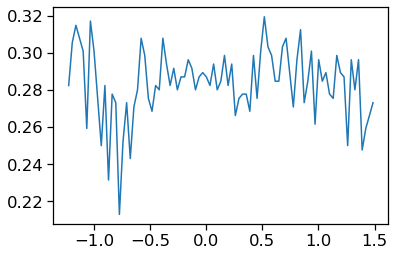

In [129]:
#simulated data for multiple random datasets
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV


# Initialize arrays to store results
n_simulations = 50
acc2 = np.zeros((T, n_simulations))  # Shape: (85, 100)
conf_mat2 = np.zeros((4, 4, T, n_simulations))  # Shape: (4, 4, 85, 100)

for sim in range(n_simulations):
    # Simulating random data
    np.random.seed(sim)  # For reproducibility
    X_simulated = np.random.randn(432, 97, 85)
    y_simulated = np.zeros(len(y), dtype=int)
    
    # Get the proportions of each category in y
    category_counts = Counter(y)
    total_samples = len(y)
    current_index = 0
    
    for category, count in category_counts.items():
        y_simulated[current_index:current_index + count] = category
        current_index += count
    
    # Shuffle y_simulated to randomize the order
    np.random.shuffle(y_simulated)
    
    # Perform k-fold cross-validation
    n_folds = 10
    folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=123)
    
    for i, (train_ind, test_ind) in enumerate(folds.split(X_simulated[:, :, 0], y_simulated)):
        for t in range(T):
            X_train = X_simulated[train_ind, :, t]
            y_train = y_simulated[train_ind]
            X_test = X_simulated[test_ind, :, t]
            y_test = y_simulated[test_ind]
            
            # Fit the model
            pipe_logistic.fit(X_train, y_train)
            
            # Predict and store results
            y_pred = pipe_logistic.predict(X_test)
            acc2[t, sim] += accuracy_score(y_test, y_pred)
            conf_mat2[:, :, t, sim] += confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3])
    
    # Normalize accuracy and confusion matrix for each simulation
    acc2[:, sim] /= n_folds
    conf_mat2[:, :, :, sim] /= n_folds

# You can now use acc2 and conf_mat2 for further analysis or plotting

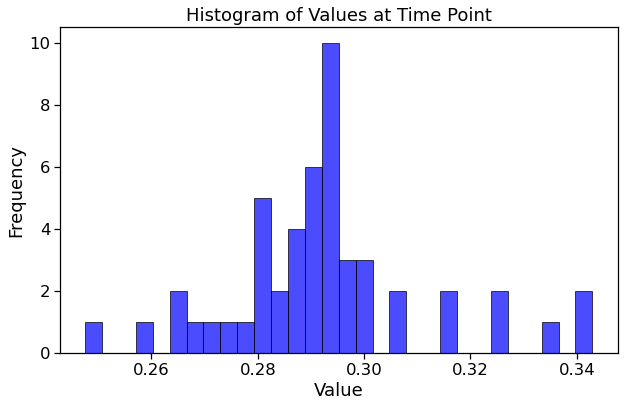

In [147]:
acc2.shape
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(acc2[40,:], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title(f'Histogram of Values at Time Point')
plt.show()

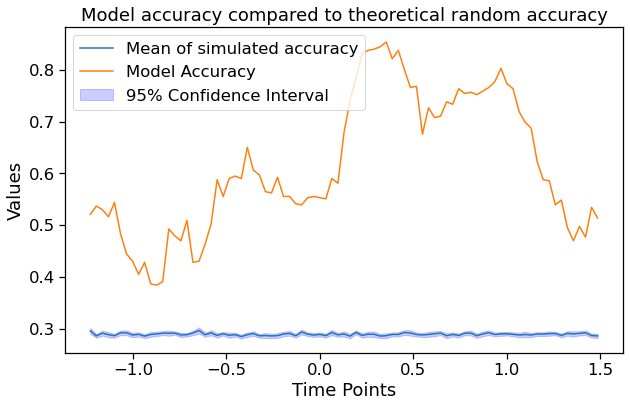

In [148]:
# Calculate the mean and standard error of the mean (SEM)
mean_values = np.mean(acc2, axis=1)
sem_values = np.std(acc2, axis=1) / np.sqrt(acc2.shape[1])

# Calculate the 95% confidence intervals
ci_upper = mean_values + 1.96 * sem_values
ci_lower = mean_values - 1.96 * sem_values

# Plotting

plt.figure(figsize=(10, 6))
plt.plot(time, mean_values, label='Mean of simulated accuracy')
plt.plot(time, acc, label = 'Model Accuracy')
plt.fill_between(time, ci_lower, ci_upper, color='b', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Time Points')
plt.ylabel('Values')
plt.title('Model accuracy compared to theoretical random accuracy')
plt.legend()
plt.savefig("simulatedAcc.jpeg", dpi=400,bbox_inches='tight')
plt.show()